## Download and Setup Pyspark

In [1]:

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

## set up the java and spark path

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

## create spark session

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

## load the data into pyspark

In [4]:
# Load data from csv to a dataframe. 
# header=True means the first row is a header 
df = spark.read.csv('uber.csv', header=True)
df.show(5)

+--------+--------------------+-----------+--------------------+------------------+-----------------+------------------+-----------------+---------------+
|     _c0|                 key|fare_amount|     pickup_datetime|  pickup_longitude|  pickup_latitude| dropoff_longitude| dropoff_latitude|passenger_count|
+--------+--------------------+-----------+--------------------+------------------+-----------------+------------------+-----------------+---------------+
|24238194|2015-05-07 19:52:...|        7.5|2015-05-07 19:52:...|-73.99981689453125|40.73835372924805|   -73.99951171875|40.72321701049805|              1|
|27835199|2009-07-17 20:04:...|        7.7|2009-07-17 20:04:...|        -73.994355|        40.728225|         -73.99471|        40.750325|              1|
|44984355|2009-08-24 21:45:...|       12.9|2009-08-24 21:45:...|        -74.005043|         40.74077|        -73.962565|        40.772647|              1|
|25894730|2009-06-26 08:22:...|        5.3|2009-06-26 08:22:...|      

# Import Libraries

In [1]:
print("hello")

hello


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import DistanceMetric
from math import *

# Load Data

### Data Source:
https://www.kaggle.com/datasets/yasserh/uber-fares-dataset

## load data into pandas from pyspark

In [6]:
fare_data = df.toPandas()

In [94]:
fare_data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1.0
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1.0
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1.0
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3.0
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5.0


In [6]:
fare_data.dtypes

Unnamed: 0             int64
key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [17]:
fare_data[['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']] = fare_data[['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']].astype(float)
fare_data['pickup_datetime'] = pd.to_datetime(fare_data['pickup_datetime'])

## now check the datatypes

In [18]:
fare_data.dtypes

Unnamed: 0                         int64
key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                  float64
dtype: object

In [19]:
fare_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   Unnamed: 0         200000 non-null  int64              
 1   key                200000 non-null  object             
 2   fare_amount        200000 non-null  float64            
 3   pickup_datetime    200000 non-null  datetime64[ns, UTC]
 4   pickup_longitude   200000 non-null  float64            
 5   pickup_latitude    200000 non-null  float64            
 6   dropoff_longitude  199999 non-null  float64            
 7   dropoff_latitude   199999 non-null  float64            
 8   passenger_count    200000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(1), object(1)
memory usage: 13.7+ MB


Only two column with missing data, i.e, dropoff_longitude and dropoff_latitude

Mix of numerical and categorical variables:
- Numerical Variables:
    - pickup_datetime
    - pickup_latitude
    - pickup_longitude
    - dropoff_latitude
    - dropoff_longitude
- Categorical Variables:
    - passanger_count

Target variable is fare_amount

In [20]:
data = fare_data

In [21]:
data.nunique()

Unnamed: 0           200000
key                  200000
fare_amount            1244
pickup_datetime      196629
pickup_longitude      71066
pickup_latitude       83835
dropoff_longitude     76894
dropoff_latitude      90585
passenger_count           8
dtype: int64

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   Unnamed: 0         200000 non-null  int64              
 1   key                200000 non-null  object             
 2   fare_amount        200000 non-null  float64            
 3   pickup_datetime    200000 non-null  datetime64[ns, UTC]
 4   pickup_longitude   200000 non-null  float64            
 5   pickup_latitude    200000 non-null  float64            
 6   dropoff_longitude  199999 non-null  float64            
 7   dropoff_latitude   199999 non-null  float64            
 8   passenger_count    200000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(1), object(1)
memory usage: 13.7+ MB


dropoff_longitude and dropoff_latitude have one missing row. We need to exclude this

In [23]:
data.nunique()

Unnamed: 0           200000
key                  200000
fare_amount            1244
pickup_datetime      196629
pickup_longitude      71066
pickup_latitude       83835
dropoff_longitude     76894
dropoff_latitude      90585
passenger_count           8
dtype: int64

In [24]:
# Dropping the columns 'Unnamed: 0' and 'key' as well as NA rows

data = data.drop(['Unnamed: 0','key'],axis=1)
data.dropna(axis=0,inplace=True)

## Data Pre-processing

In [25]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,199999.0,11.359892,9.901760,-52.000000,6.000000,8.500000,12.500000,499.000000
pickup_longitude,199999.0,-72.527631,11.437815,-1340.648410,-73.992065,-73.981823,-73.967154,57.418457
pickup_latitude,199999.0,39.935881,7.720558,-74.015515,40.734796,40.752592,40.767158,1644.421482
dropoff_longitude,199999.0,-72.525292,13.117408,-3356.666300,-73.991407,-73.980093,-73.963658,1153.572603
dropoff_latitude,199999.0,39.923890,6.794829,-881.985513,40.733823,40.753042,40.768001,872.697628
passenger_count,199999.0,1.684543,1.385995,0.000000,1.000000,1.000000,2.000000,208.000000


Possibility of some outliers in fare amount and passanger

Outliers:
- Fare Amount is between -52 to 499. The negative amount seems unrealistic. Base fare to be set at $2.5
- Passanger count max is 208, which is also not possible. Max to be set at 5

### Identifying Correlations

In [26]:
# Identify Correlation
data.corr()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
fare_amount,1.000000,0.122765,0.010458,-0.008482,0.008986,-0.011014,0.010158
pickup_datetime,0.122765,1.000000,0.009363,-0.009677,0.008018,-0.010805,0.006398
pickup_longitude,0.010458,0.009363,1.000000,-0.816461,0.833026,-0.846324,-0.000415
pickup_latitude,-0.008482,-0.009677,-0.816461,1.000000,-0.774787,0.702367,-0.001559
dropoff_longitude,0.008986,0.008018,0.833026,-0.774787,1.000000,-0.917010,0.000033
dropoff_latitude,-0.011014,-0.010805,-0.846324,0.702367,-0.917010,1.000000,-0.000659
passenger_count,0.010158,0.006398,-0.000415,-0.001559,0.000033,-0.000659,1.000000


<Axes: >

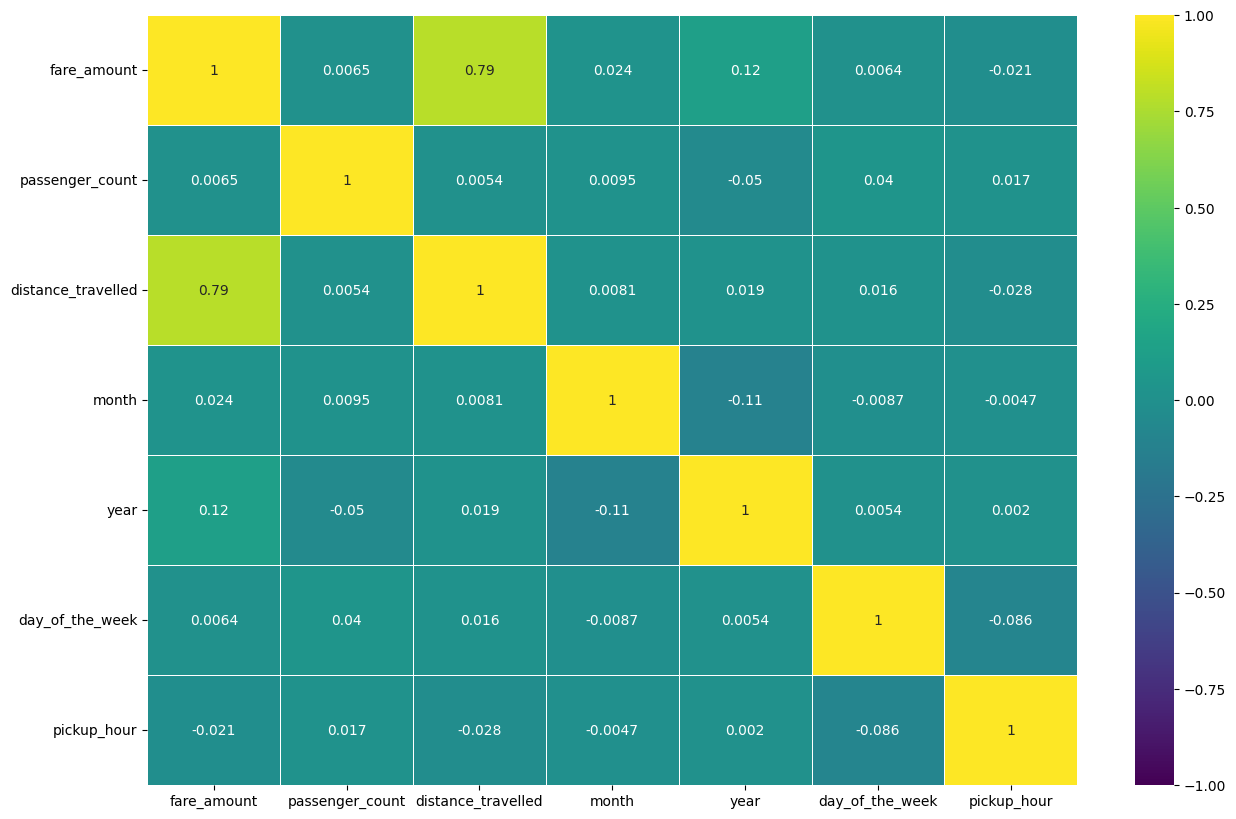

In [95]:
# Plot the Correlation matrix
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True, linewidths=.5, vmin = -1, vmax = 1, fmt = '.2g', cmap='viridis')

High correlation can be observed between the geo-spatial data points, which was expected. Therefore, there is no need to drop any of the independent variables

In [29]:
# Define formula to calculate haversine distance
def distance(longitude1, latitude1, longitude2, latitude2):
    travel_dist = []
    
    for pos in range(len(longitude1)):
        long1,lati1,long2,lati2 = map(radians,[longitude1[pos],latitude1[pos],longitude2[pos],latitude2[pos]])
        dist_long = long2 - long1
        dist_lati = lati2 - lati1
        a = sin(dist_lati/2)**2 + cos(lati1) * cos(lati2) * sin(dist_long/2)**2
        c = 2 * asin(sqrt(a))*6371
        travel_dist.append(c)
       
    return travel_dist

In [30]:
data.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                  float64
dtype: object

In [31]:
# Calculate Haversine distance for each row and add distance in km as a new column
data['distance_travelled'] = distance(data['pickup_longitude'].to_numpy(),
                                                data['pickup_latitude'].to_numpy(),
                                                data['dropoff_longitude'].to_numpy(),
                                                data['dropoff_latitude'].to_numpy()
                                              )

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199999 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   fare_amount         199999 non-null  float64            
 1   pickup_datetime     199999 non-null  datetime64[ns, UTC]
 2   pickup_longitude    199999 non-null  float64            
 3   pickup_latitude     199999 non-null  float64            
 4   dropoff_longitude   199999 non-null  float64            
 5   dropoff_latitude    199999 non-null  float64            
 6   passenger_count     199999 non-null  float64            
 7   distance_travelled  199999 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 13.7 MB


In [33]:
# As we can see, pickup_datetime is being read as an object data type. However, we need to convert it into datetime data type
data['pickup_datetime']  = pd.to_datetime(data['pickup_datetime'])

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199999 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   fare_amount         199999 non-null  float64            
 1   pickup_datetime     199999 non-null  datetime64[ns, UTC]
 2   pickup_longitude    199999 non-null  float64            
 3   pickup_latitude     199999 non-null  float64            
 4   dropoff_longitude   199999 non-null  float64            
 5   dropoff_latitude    199999 non-null  float64            
 6   passenger_count     199999 non-null  float64            
 7   distance_travelled  199999 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 13.7 MB


In [35]:
# From pickup_datetime extract date, month, year, weekday and dayname
from datetime import datetime

data['date'] = pd.to_datetime(data['pickup_datetime']).dt.date
data['month'] = pd.to_datetime(data['pickup_datetime']).dt.month
data['year'] = pd.to_datetime(data['pickup_datetime']).dt.year
data['day_of_the_week'] = pd.to_datetime(data['pickup_datetime']).dt.weekday
data['day_name'] = pd.to_datetime(data['pickup_datetime']).dt.day_name()
data['pickup_time'] = pd.to_datetime(data['pickup_datetime']).dt.time
data['pickup_hour'] = pd.to_datetime(data['pickup_datetime']).dt.hour

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199999 entries, 0 to 199999
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   fare_amount         199999 non-null  float64            
 1   pickup_datetime     199999 non-null  datetime64[ns, UTC]
 2   pickup_longitude    199999 non-null  float64            
 3   pickup_latitude     199999 non-null  float64            
 4   dropoff_longitude   199999 non-null  float64            
 5   dropoff_latitude    199999 non-null  float64            
 6   passenger_count     199999 non-null  float64            
 7   distance_travelled  199999 non-null  float64            
 8   date                199999 non-null  object             
 9   month               199999 non-null  int32              
 10  year                199999 non-null  int32              
 11  day_of_the_week     199999 non-null  int32              
 12  day_name            1

### Outlier Treatment

The following treatment is being done to outliers:
- passanger_count should be less than 5
- rows with passanger_count = 0 should be dropped
- fare_amount should be kept to the minimum set by Uber, i.e., $2.5
- distance should be maximum 130 km
- distance travelled cannot be zero. Rows with distance = 0 must be dropped

In [37]:
data.drop(data[data['passenger_count'] > 5].index, axis=0, inplace = True)
data.drop(data[data['passenger_count'] == 0].index, axis=0, inplace = True)
data.drop(data[data['fare_amount'] < 2.5].index, axis=0, inplace = True)
data.drop(data[data['distance_travelled'] > 130].index, axis=0, inplace = True)
data.drop(data[data['distance_travelled'] == 0].index, axis=0, inplace = True)
data.dropna(axis=0,inplace=True)

In [38]:
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_travelled,date,month,year,day_of_the_week,day_name,pickup_time,pickup_hour
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1.0,1.683323,2015-05-07,5,2015,3,Thursday,19:52:06,19
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1.0,2.457590,2009-07-17,7,2009,4,Friday,20:04:56,20
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1.0,5.036377,2009-08-24,8,2009,0,Monday,21:45:00,21
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3.0,1.661683,2009-06-26,6,2009,4,Friday,08:22:21,8
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5.0,4.475450,2014-08-28,8,2014,3,Thursday,17:47:00,17


In [39]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,189061.0,11.336739,9.730745,2.500000,6.000000,8.500000,12.500000,499.000000
pickup_longitude,189061.0,-73.916225,2.560946,-75.419276,-73.992274,-73.982133,-73.968465,40.808425
pickup_latitude,189061.0,40.696089,2.634751,-74.015515,40.736440,40.753273,40.767532,401.066667
dropoff_longitude,189061.0,-73.915258,2.561027,-75.423067,-73.991594,-73.980564,-73.965513,40.831932
dropoff_latitude,189061.0,40.694481,2.501323,-74.015750,40.735345,40.753738,40.768327,45.031598
passenger_count,189061.0,1.595115,1.150926,1.000000,1.000000,1.000000,2.000000,5.000000
distance_travelled,189061.0,3.377859,3.984585,0.000084,1.279954,2.181325,3.938054,129.610094
month,189061.0,6.282337,3.439349,1.000000,3.000000,6.000000,9.000000,12.000000
year,189061.0,2011.719302,1.862527,2009.000000,2010.000000,2012.000000,2013.000000,2015.000000
day_of_the_week,189061.0,3.049095,1.946679,0.000000,1.000000,3.000000,5.000000,6.000000


In [40]:
# Dropping the columns 'pickup datetime' and 'pickup hour' as we have extracted relvant pieces of information
# from these columns and do not need these columns for our analysis now. Also, 'date' and 'day_name', month and yuear
# as well as pickup and dropoff coordinates are not required as we have the required data extracted from them

data = data.drop(['pickup_datetime','pickup_time', 'date', 'pickup_longitude', 'pickup_latitude',
                  'dropoff_longitude', 'dropoff_latitude', 'day_name'],axis=1)

In [92]:
data.columns

Index(['fare_amount', 'passenger_count', 'distance_travelled', 'month', 'year',
       'day_of_the_week', 'pickup_hour'],
      dtype='object')

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 189061 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fare_amount         189061 non-null  float64
 1   passenger_count     189061 non-null  float64
 2   distance_travelled  189061 non-null  float64
 3   month               189061 non-null  int32  
 4   year                189061 non-null  int32  
 5   day_of_the_week     189061 non-null  int32  
 6   pickup_hour         189061 non-null  int32  
dtypes: float64(3), int32(4)
memory usage: 8.7 MB


# Numerical Features - Univariate Analysis

## Boxplot & Histogram

### Distance

<Axes: xlabel='distance_travelled'>

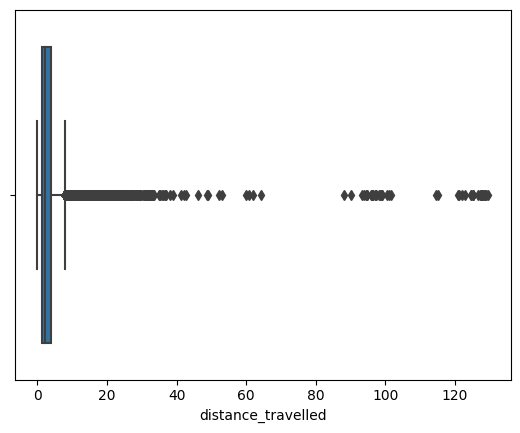

In [42]:
sns.boxplot(x=data['distance_travelled'])

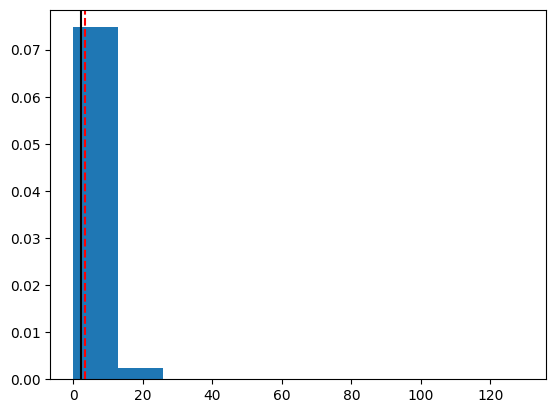

In [43]:
import matplotlib.pyplot as plt
hist = plt.hist(x=data['distance_travelled'], density = True)
# Draw a vertical line in the histogram to visualize mean value of the numerical feature (NaNs will be ignored when calculating the mean)
plt.axvline(data['distance_travelled'].mean(), color = 'red', linestyle='--')
# Draw another vertical line in the histogram to visualize median value of the numerical feature (NaNs will be ignored when calculating the median)
plt.axvline(data['distance_travelled'].median(), color = 'black', linestyle='-')

Observations:
- Negatively Skewed
- Outliers on the left end
- Mean and Median are close

# Categorical Features - Univariate Analysis

### Passenger Count

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '1.0'),
  Text(1, 0, '2.0'),
  Text(2, 0, '5.0'),
  Text(3, 0, '3.0'),
  Text(4, 0, '4.0')])

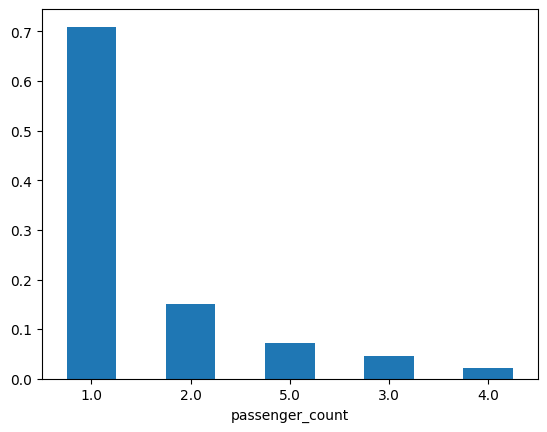

In [44]:
data['passenger_count'].value_counts(normalize = True).plot.bar()
plt.xticks(rotation = 0)

Observation:
- Almost 70% of trips had only 1 passanger

### Day of the week

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '4'),
  Text(1, 0, '5'),
  Text(2, 0, '3'),
  Text(3, 0, '2'),
  Text(4, 0, '1'),
  Text(5, 0, '6'),
  Text(6, 0, '0')])

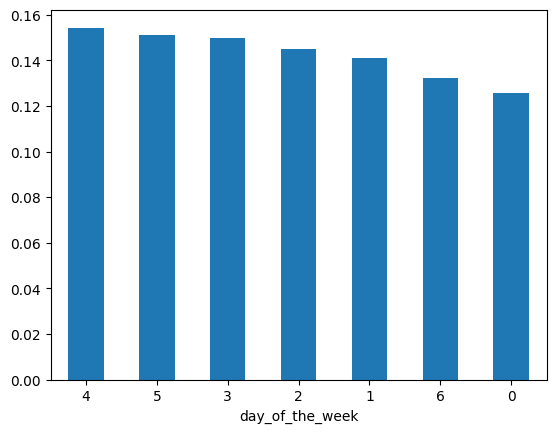

In [45]:
data['day_of_the_week'].value_counts(normalize = True).plot.bar()
plt.xticks(rotation = 0)

Observation:
- As expected, Friday (weekend eve) and Saturday had the highest number of trips

### Pickup Time

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, '19'),
  Text(1, 0, '18'),
  Text(2, 0, '20'),
  Text(3, 0, '21'),
  Text(4, 0, '22'),
  Text(5, 0, '13'),
  Text(6, 0, '12'),
  Text(7, 0, '23'),
  Text(8, 0, '14'),
  Text(9, 0, '17'),
  Text(10, 0, '15'),
  Text(11, 0, '11'),
  Text(12, 0, '9'),
  Text(13, 0, '8'),
  Text(14, 0, '10'),
  Text(15, 0, '16'),
  Text(16, 0, '0'),
  Text(17, 0, '7'),
  Text(18, 0, '1'),
  Text(19, 0, '2'),
  Text(20, 0, '6'),
  Text(21, 0, '3'),
  Text(22, 0, '4'),
  Text(23, 0, '5')])

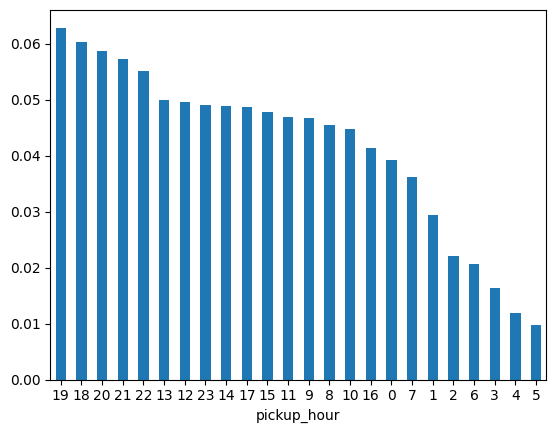

In [46]:
data['pickup_hour'].value_counts(normalize = True).plot.bar()
plt.xticks(rotation = 0)

Observation:
- As expected, the number of trips are low during 1am - 5am, and peak between 7pm - 9pm

We can clearly see that during weekdays, peak hours are during the day while on weekends, peak hours are late in the night

# Bivariate / Multivariate Analysis

In [47]:
!pip install geopandas
import geopandas as gpd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 346.7 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 256.9 kB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 1.1 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.0/157.0 kB 158.3 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 491.5 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


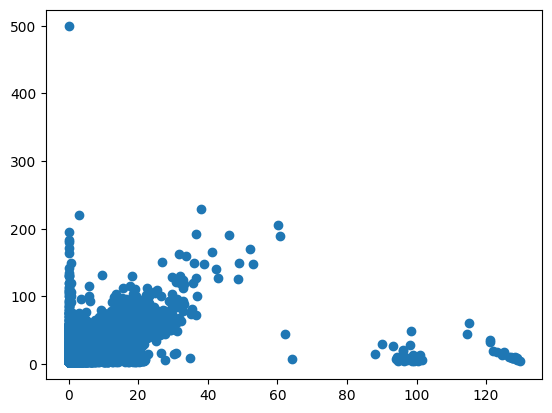

In [48]:
#Scatte plot of distance vs fare amount
plt.scatter(x = data.distance_travelled, y = data.fare_amount)

# Show the plot
plt.show()

Generally, as distance increases, the fare amount also increases with a few sporadic inconsistencies

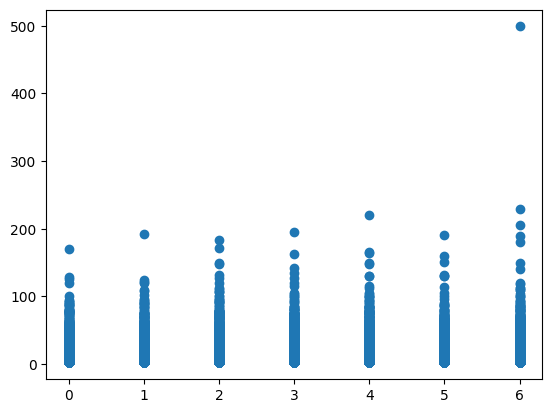

In [49]:
#Scatte plot of day of the week vs fare amount
plt.scatter(x = data.day_of_the_week, y = data.fare_amount)

# Show the plot
plt.show()

Generally speaking, weekend fares are higher than weekday fares. This could be due to distance travelled or due to peak hours

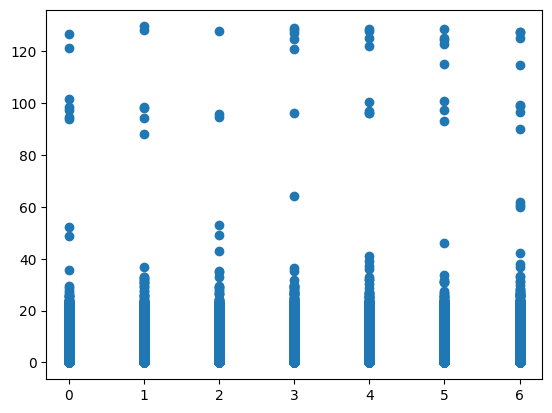

In [50]:
#Scatte plot of day of the week vs distance to see if there is any relationship between them
plt.scatter(x = data.day_of_the_week, y = data.distance_travelled)

# Show the plot
plt.show()

We see that there isn;t much of a relationship between distance travelled vs fay of the week - thus, it is appears that fare amount being higher on weekends has a high likelihood of being linked to peak hours / wait time due to higher traffic.

Unfortunately, we do not have the dropoff time for each ride to be able to ascertain the time of each trip and demonstrate if we can see a relationship between fare and time travelled

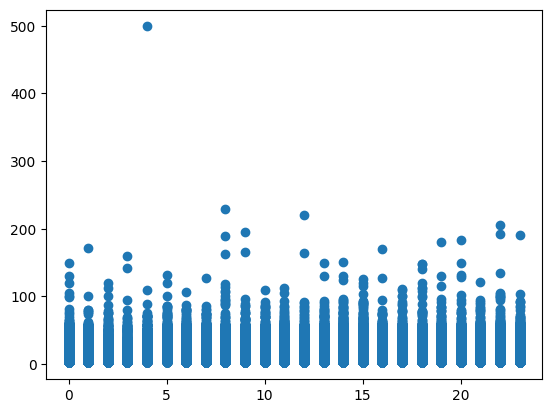

In [51]:
#Scatte plot of pickup time vs fare amount
plt.scatter(x = data.pickup_hour, y = data.fare_amount)

# Show the plot
plt.show()

We do see some pickup times having a greater % of higher fares as compared to others - however, it is difficult to draw a concluding relationship

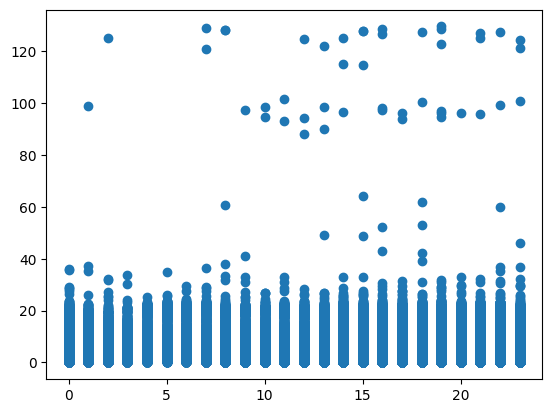

In [52]:
#Scatte plot of pickup time vs distance
plt.scatter(x = data.pickup_hour, y = data.distance_travelled)

# Show the plot
plt.show()

Some pickup hours have a greater concentration of trips where a high distance was travelled as compared to others

### Data Preparatrion

### Feature Scaling

Feature Scaling is required because of two reasons:
1. The data points are far from each other. This means that in some columns, the distance between data points is a lot
2. Some of the features have a unit while other features are unitless. Thereofre, it is important to make all features unitless

In [53]:
#Feature Scaling (Standardization)

from sklearn.preprocessing import StandardScaler

std = StandardScaler()

In [54]:
x = data.drop(['fare_amount'], axis = 1)
y = data['fare_amount'].values.reshape(-1, 1)

In [55]:
y_std = std.fit_transform(y)

x_std = std.fit_transform(x)

In [56]:
x_train, x_test, y_train, y_test = train_test_split(x_std, y_std, test_size = 0.3, random_state = 42)

In [57]:
x_train.shape

(132342, 6)

In [58]:
y_train.shape

(132342, 1)

In [59]:
x_test.shape

(56719, 6)

In [60]:
y_test.shape

(56719, 1)

# Regression Models

## Linear Regression

In [83]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(x_train,y_train)

LinearRegression()

In [84]:
LR_pred = LR.predict(x_test)

In [85]:
print("Training set score: {:.2f}".format(LR.score(x_train, y_train)))
print("Test set score: {:.7f}".format(LR.score(x_test, y_test)))

Training set score: 0.65
Test set score: 0.5782372


In [86]:
import pickle
pickle.dump(LR, open('models/linear_model.pkl','wb'))

In [73]:
from sklearn import metrics
from sklearn.metrics import r2_score

MAE_LR= metrics.mean_absolute_error(y_test, LR_pred)
MSE_LR= metrics.mean_squared_error(y_test, LR_pred)
RMSE_LR= np.sqrt(metrics.mean_squared_error(y_test, LR_pred))
r2_LR=r2_score(y_test, LR_pred)
Adj_r2_LR=1-(1-r2_score(y_test, LR_pred))*((len(x_test)-1)/(len(x_test)-len(x_test[0])-1))

### Decision Tree Regressor

In [88]:
from sklearn.tree import DecisionTreeRegressor

DT = DecisionTreeRegressor()
DT.fit(x_train, y_train)

DecisionTreeRegressor()

In [89]:
DTpreds = DT.predict(x_test)
import pickle
pickle.dump(DT, open('models/decision_tree_model.pkl','wb'))

In [77]:
print("Training set score: {:.2f}".format(DT.score(x_train, y_train)))
print("Test set score: {:.7f}".format(DT.score(x_test, y_test)))

Training set score: 1.00
Test set score: 0.6234840


In [ ]:
MAE_DT= metrics.mean_absolute_error(y_test, DTpreds)
MSE_DT= metrics.mean_squared_error(y_test, DTpreds)
RMSE_DT= np.sqrt(metrics.mean_squared_error(y_test, DTpreds))
r2_DT=r2_score(y_test, DTpreds)
Adj_r2_DT=1-(1-r2_score(y_test, DTpreds))*((len(x_test)-1)/(len(x_test)-len(x_test[0])-1))